In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from src.utils.preprocess import *
from src.utils.generate_operating_condition import *
from src.utils.config import *
from src.models.model import *
from src.utils.util import *

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow import keras
from sklearn.model_selection import train_test_split


In [3]:
input_path="./dataset/processed/input/"
output_path="./dataset/processed/output/"
boundary_no_obs_path=input_path+"cnn_input/no_obstacle/"
driving_no_obs_path=input_path+"text_input/no_obstacle/"
label_no_obs_path=output_path+"no_obstacle/"

## 1. 데이터구성

#### 데이터로드

In [4]:
boundary_data=np.load(boundary_no_obs_path+'boundary_condition.npy')
driving_data=np.load(driving_no_obs_path+'driving_condition.npy')
label_data=np.load(label_no_obs_path+'label.npy')

In [5]:
boundary_data.shape, driving_data.shape, label_data.shape

((315, 460800), (315, 10), (315, 120, 60, 64))

#### 데이터전처리

In [6]:
simul_config = simulaion_config()
x_dim = simul_config.x_dim
y_dim = simul_config.y_dim
z_dim = simul_config.z_dim

In [7]:
# 공간정보 데이터
boundary_data_s = []
for i in boundary_data:
    i=i.reshape(120,60,64,1)
    boundary_data_s.append(i)
boundary_data = np.array(boundary_data_s).astype("float64")
boundary_data.shape

(315, 120, 60, 64, 1)

In [9]:
# 운전정보 데이터
char2idx,idx2char=generate_no_obstacle_operating_data()
driving_data=operating_division(driving_data,idx2char)
driving_config=operating_condition_max_value_config(driving_data)
driving_data=operating_scaling(driving_data,driving_config)

special_token=[]
special_value=[]
for i in range(len(driving_data)):
    special_token.append(driving_data[:,0][i])
    special_value.append(driving_data[:,1][i])
special_token=np.array(special_token)
special_value=np.array(special_value)
special_token.shape,special_value.shape

((315, 5), (315, 5))

In [10]:
# 레이블 데이터
max_label = np.max(label_data)
min_label = np.min(label_data)

label_data = (label_data-min_label)/(max_label-min_label)
np.max(label_data), np.min(label_data)

(1.0, 0.0)

In [11]:
boundary_data.shape, driving_data.shape, label_data.shape

((315, 120, 60, 64, 1), (315, 2, 5), (315, 120, 60, 64))

#### 데이터분할

In [12]:
train_ratio = 0.75
valid_ratio = 0.15
test_ratio = 0.10
first_split_size=1-train_ratio
second_split_size=test_ratio/(test_ratio+valid_ratio)

cnn_train, cnn_tv, label_train, label_tv = train_test_split(boundary_data, label_data, test_size=first_split_size, random_state=42)
cnn_val, cnn_test, label_val, label_test = train_test_split(cnn_tv, label_tv, test_size=second_split_size, random_state=42)
spe_tok_train, spe_tok_tv, val_tok_train, val_tok_tv = train_test_split(special_token, special_value, test_size=first_split_size, random_state=42)
spe_tok_val, spe_tok_test, val_tok_val, val_tok_test = train_test_split(spe_tok_tv, val_tok_tv, test_size=second_split_size, random_state=42)

#### 데이터구성

In [13]:
X_train = [cnn_train, spe_tok_train, val_tok_train]
X_test = [cnn_test, spe_tok_test, val_tok_test]
X_val = [cnn_val, spe_tok_val, val_tok_val]
Y_train = label_train
Y_test = label_test
Y_val = label_val
print("X_train ",X_train[0].shape)
print("X_val ",X_val[0].shape)
print("X_test ",X_test[0].shape)
print("Y_train ",Y_train.shape)
print("Y_val ",Y_val.shape)
print("Y_test ",Y_test.shape,'\n')

X_train  (236, 120, 60, 64, 1)
X_val  (47, 120, 60, 64, 1)
X_test  (32, 120, 60, 64, 1)
Y_train  (236, 120, 60, 64)
Y_val  (47, 120, 60, 64)
Y_test  (32, 120, 60, 64) 



In [14]:
cnn_test.shape,spe_tok_test.shape,val_tok_test.shape

((32, 120, 60, 64, 1), (32, 5), (32, 5))

## 2. 모델구성

#### 모델정의

In [15]:
model_config=get_transformer_config()

In [16]:
model=CFDUnet(model_config)

#### 모델 컴파일

In [17]:
initial_learning_rate = 1e-5

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

model.compile(
    loss='mae',
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["mae","mse"],
)

#### 모델 경로지정

In [18]:
# 모델 저장 경로정의
WEIGHT_PATH = 'checkpoints/'
model_name = 'transUnet/'
test_num = 100
TEST_DIR = 'TEST' + str(test_num) + '/'
# 경로지정
checkpoint_path = WEIGHT_PATH + model_name + TEST_DIR + "TEST" + str(test_num)
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))

checkpoints/transUnet/TEST100 -- Folder create complete 



#### callback 함수 지정

In [19]:
# EarlyStopping
earlystop_callback = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=50)

# Tensorboard
log_dir = "logs/fit/" + 'TEST' + str(test_num) + "" 

if os.path.exists(log_dir):
    print("{} -- Folder already exists \n".format(log_dir))
else:
    os.makedirs(log_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(log_dir))
    
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# checkpoint
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

logs/fit/TEST100 -- Folder create complete 



## 3. 학습

In [20]:
BATCH_SIZE = 1

In [21]:
history = model.fit(X_train, Y_train, 
                      validation_data=(X_val,Y_val),
                      batch_size=BATCH_SIZE, epochs=1000,
                      callbacks=[earlystop_callback, cp_callback, tensorboard_callback])

Epoch 1/1000
x : (1, 120, 60, 64, 1)
text1 : (1, 5)
text2 : (1, 5)
pre dense layer x : (1, 15, 7, 8, 256)
after dense layer x : (1, 15, 7, 8, 256)
after down sampling x : (1, 840, 256)
x : (1, 840, 256)
tokens : Tensor("IteratorGetNext:1", shape=(1, 5), dtype=float32)
values : Tensor("IteratorGetNext:2", shape=(1, 5), dtype=float32)
toks : Tensor("cfd_unet/numerical_dense/embedding/embedding_lookup/Identity_1:0", shape=(1, 5, 256), dtype=float32)
vals : Tensor("cfd_unet/numerical_dense/dense_1/Relu:0", shape=(1, 5, 256), dtype=float32)
vals+toks : (1, 5, 256)
outputs : (1, 256)
outputs : (1, 1, 256)
text : (1, 1, 256)
text : (1, 840, 256)
결합한뒤 x: (1, 840, 256)
레이어 정규화후 x: (1, 840, 256)
dense layer 통과 후 x: (1, 840, 256)


KeyboardInterrupt: 

## 4. 학습결과 확인

In [20]:
%load_ext tensorboard

In [21]:
%tensorboard --logdir logs/fit --host localhost --port 8888

Reusing TensorBoard on port 8888 (pid 38840), started 1:23:34 ago. (Use '!kill 38840' to kill it.)

## 5. 테스트

In [22]:
checkpoint_path

'checkpoints/transUnet/TEST1/TEST1'

In [23]:
model.load_weights(checkpoint_path)

In [24]:
prediction = model.predict(X_test,batch_size=1)

#### 역스케일링

In [25]:
for num in range(len(prediction)):
    prediction[num]=prediction[num]*(max_label-min_label)+min_label
    Y_test[num]=Y_test[num]*(max_label-min_label)+min_label

#### 플로팅

In [26]:
# 플로팅시 사용될 데이터프레임 로드 
csv_lst=os.listdir("dataset/dataframe/no_obstacle/")
csv_lst = sorted([int(i.strip(".csv")) for i in csv_lst])
csv_lst = [str(i)+".csv" for i in csv_lst]

# 데이터프레임 분할
df_train, df_tv = train_test_split(csv_lst, test_size=first_split_size, random_state=42)
df_val, df_test = train_test_split(df_tv, test_size=second_split_size, random_state=42)

# 시뮬레이션 운전조건 확인위한 데이터프레임
simulation_df = pd.read_csv("src/data/simulation/processed/no_obstacle.csv")

시뮬레이션 조건 : File name            dp045.txt
inlet_velocity            2.38
inlet_temperature           10
wall_temperature            10
Angle                       80
Name: 45, dtype: object


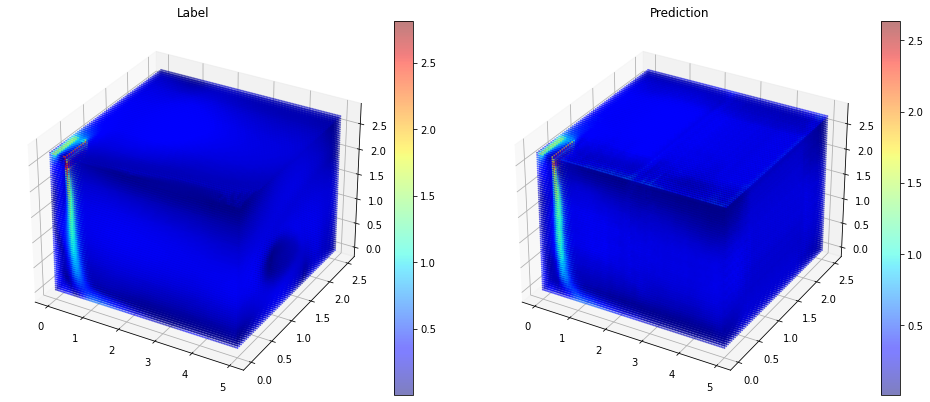

In [27]:
# 플롯할 테스트넘버 및 운전조건
plot_num=15
print("시뮬레이션 조건 :",simulation_df.loc[int(df_test[plot_num].strip(".csv"))])

df = pd.read_csv(f"dataset/dataframe/no_obstacle/{df_test[plot_num]}")
fig = plt.figure(figsize=(16,20))

# Label
ax = fig.add_subplot(121, projection='3d')
plt.title('Label')
im=ax.scatter(df['x'], df['y'], df['z'], c=Y_test[plot_num], s=1, alpha=0.5, cmap='jet')
plt.colorbar(im, fraction=0.046, pad=0.04)

# Prediction
ax = fig.add_subplot(122, projection='3d')
plt.title('Prediction')
im=ax.scatter(df['x'], df['y'], df['z'], c=prediction[plot_num], s=1, alpha=0.5, cmap='jet')
plt.colorbar(im, fraction=0.046, pad=0.04)

## 6. Interpolation test

In [28]:
cnn_test=X_test[0][0:1]
spe_test=X_test[1][0:1]

# 입구속도 입구온도 벽온도 각도 None
val_test=np.array([2.2,50, 10, 52, 0.])
val_test=scaling_for_IE_ploation(val_test,driving_config)

# 데이터구성
X_interpolation=[cnn_test,spe_test,val_test]

In [29]:
Y_interpolation=model.predict(X_interpolation,batch_size=1)

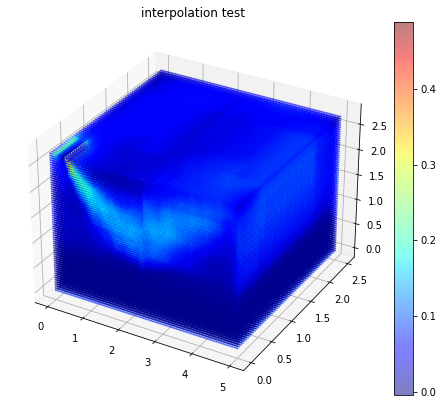

In [30]:
df = pd.read_csv(f"dataset/dataframe/no_obstacle/0.csv")
fig = plt.figure(figsize=(16,20))

# interpolation test
ax = fig.add_subplot(121, projection='3d')
plt.title('interpolation test')
im=ax.scatter(df['x'], df['y'], df['z'], c=Y_interpolation, s=1, alpha=0.5, cmap='jet')
plt.colorbar(im, fraction=0.046, pad=0.04)